### 1. 라이브러리 호출

In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

---------------

### 2. 데이터 불러오기

In [117]:
# 건물정보 데이터셋
building = pd.read_csv('data/building_info.csv')

# 날씨/전력사용량 데이터셋 (건물/시간대별)
train = pd.read_csv('data/train.csv')

# 날씨/전력사용량 데이터셋 (건물/시간대별)
test = pd.read_csv('data/test.csv')

In [118]:
# 한글폰트 사용: 'NanumGothic' 폰트를 사용합니다.
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 문제 해결

---------------

### 3-1. 결측치 시각화

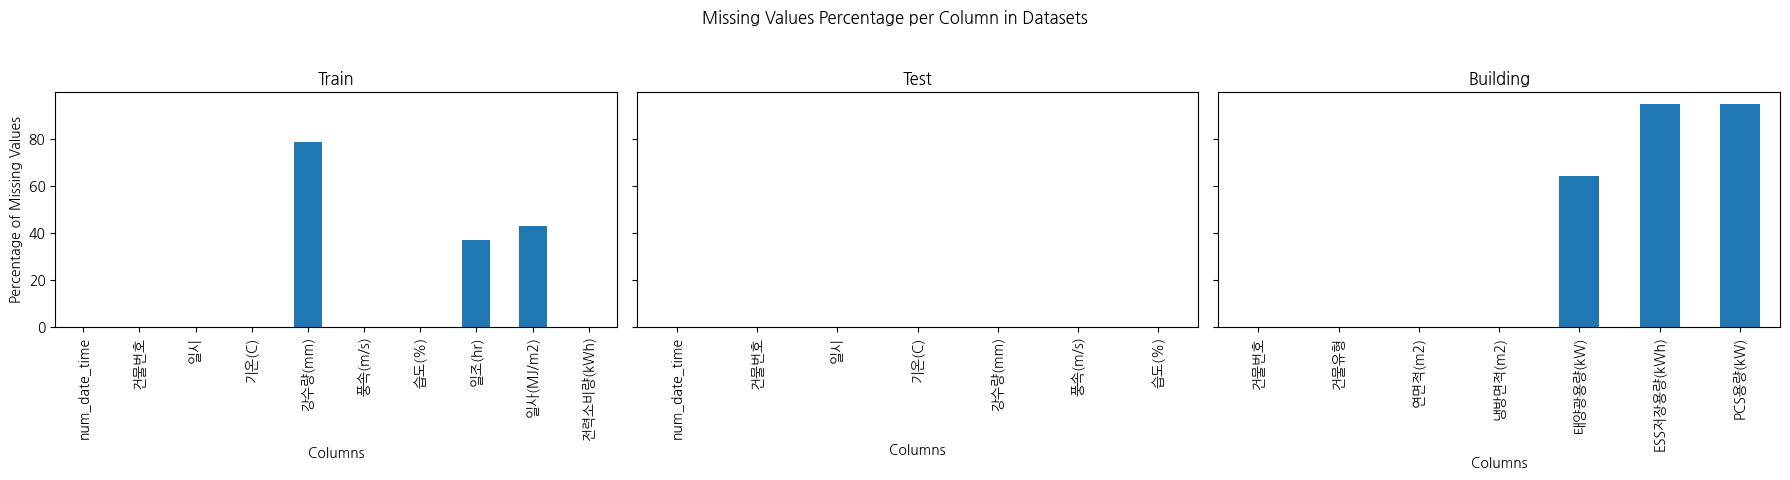

In [119]:
# '-'를 결측치로 변환하고, 결측치 비율을 계산하는 함수
def calculate_missing_values(df):
    df.replace('-', pd.NA, inplace=True)
    return df.isnull().mean() * 100

# 각 데이터프레임에 함수 적용
datasets = {'Train': train, 'Test': test, 'Building': building}
missing_data = {name: calculate_missing_values(df) for name, df in datasets.items()}

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 서브플롯들 공유 Y 축 설정
fig.suptitle('Missing Values Percentage per Column in Datasets')

for ax, (title, data) in zip(axes, missing_data.items()):
    data.plot.bar(ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Percentage of Missing Values')
    ax.set_xlabel('Columns')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 상위 제목이 잘리지 않도록 조정
plt.show()

### 3-2. 결측치가 있는 컬럼 추출하기

In [120]:
# 각 데이터셋에서 결측치가 포함된 컬럼 목록을 반환하는 함수
def find_columns_with_missing_values(df):
    missing_columns = df.columns[df.isnull().any()].tolist()
    return missing_columns

# train, test, building 데이터셋에서 결측치가 있는 컬럼 추출
missing_columns_train = find_columns_with_missing_values(train)
missing_columns_test = find_columns_with_missing_values(test)
missing_columns_building = find_columns_with_missing_values(building)

# 출력
print("Train 데이터 결측치 컬럼:", missing_columns_train)
print("Test 데이터 결측치 컬럼:", missing_columns_test)
print("Building 데이터 결측치 컬럼:", missing_columns_building)

Train 데이터 결측치 컬럼: ['강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)']
Test 데이터 결측치 컬럼: []
Building 데이터 결측치 컬럼: ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']


### 3-3. 값이 0인 행 출력하기

In [121]:
# 데이터셋에서 값이 0인 셀을 포함하는 행을 찾는 코드
def find_rows_with_any_zeros(df):
    zero_rows = df[(df == 0).any(axis=1)]
    return zero_rows

# train, test, building 데이터셋에서 값이 0인 셀을 포함하는 행 추출
rows_with_zeros_train = find_rows_with_any_zeros(train)
rows_with_zeros_test = find_rows_with_any_zeros(test)
rows_with_zeros_building = find_rows_with_any_zeros(building)

In [122]:
# building 데이터에서 값이 0인 행 출력하기
rows_with_zeros_building

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
64,65,아파트,183839.000,0.0,<NA>,<NA>,<NA>
65,66,아파트,105073.000,0.0,<NA>,<NA>,<NA>
67,68,아파트,389395.928,0.0,<NA>,<NA>,<NA>


In [123]:
# train 데이터에서 값이 0인 행 출력하기
rows_with_zeros_train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
6,1_20220601 06,1,20220601 06,16.3,NaN,1.0,50.0,0.0,0.05,1314.72
30,1_20220602 06,1,20220602 06,17.8,NaN,2.4,80.0,0.0,0.04,1390.08
31,1_20220602 07,1,20220602 07,18.4,NaN,2.6,77.0,0.0,0.27,1739.04
54,1_20220603 06,1,20220603 06,19.1,NaN,2.1,79.0,0.0,0.03,1451.04
55,1_20220603 07,1,20220603 07,19.6,NaN,1.7,77.0,0.0,0.34,1863.84
...,...,...,...,...,...,...,...,...,...,...
203989,100_20220824 13,100,20220824 13,24.7,NaN,1.4,75.0,0.0,NaN,1096.80
203990,100_20220824 14,100,20220824 14,24.9,NaN,1.2,76.0,0.0,NaN,1092.00
203991,100_20220824 15,100,20220824 15,25.1,NaN,1.2,74.0,0.0,NaN,1120.32
203992,100_20220824 16,100,20220824 16,25.6,NaN,1.4,72.0,0.0,NaN,1137.60


### 3-4. 결측치 처리 코드

In [124]:
# building 데이터셋에서 결측치가 많은 컬럼 삭제
building.drop(columns=['ESS저장용량(kWh)', 'PCS용량(kW)'], axis=1, inplace=True)
train.drop(columns=['num_date_time', '강수량(mm)', '일조(hr)', '일사(MJ/m2)'], axis=1, inplace=True)
test.drop(columns=['num_date_time', '강수량(mm)'], axis=1, inplace=True)

# 결측치르 0값으로 처리
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)
building.fillna(0, inplace=True)

--------------------